# Определение перспективного тарифа для телеком компании

## Описание проекта

Имеются данные о поведении клиентов при использовании тарифных планов. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». 
Необходимо выполнить предварительный анализ тарифов на небольшой выборке клиентов.
Исходные данные: данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
### Тариф «Смарт»
+ Ежемесячная плата: 550 рублей
+ Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
+ Стоимость услуг сверх тарифного пакета:
 + минута разговора: 3 рубля
 + сообщение: 3 рубля
 + 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
+ Ежемесячная плата: 1950 рублей
+ Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
+ Стоимость услуг сверх тарифного пакета:
 + минута разговора: 1 рубль
 + сообщение: 1 рубль
 + 1 Гб интернет-трафика: 150 рублей

Значения минут и мегабайтов округляется вверх. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Общее

### Импортируем библиотеки

In [80]:
# Импортируем библиотеки
# для работы с данными
import pandas as pd
import numpy as np

# для работы с датой
import datetime
from dateutil import relativedelta

# Для работы со статистикой
from scipy import stats as st

#Предупреждения
import warnings
warnings.filterwarnings('ignore')

# Для Графиков
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

## 1. Изучим общую информацию

### Перечень входных данных
Путь к файлам:
+ /datasets/calls.csv
+ /datasets/internet.csv
+ /datasets/messages.csv
+ /datasets/tariffs.csv
+ /datasets/users.csv

### Описание данных
Таблица `users` (информация о пользователях):
+ *user_id* — уникальный идентификатор пользователя
+ *first_name* — имя пользователя
+ *last_name* — фамилия пользователя
+ *age* — возраст пользователя (годы)
+ *reg_date* — дата подключения тарифа (день, месяц, год)
+ *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
+ *city* — город проживания пользователя
+ *tariff* — название тарифного плана

Таблица `calls` (информация о звонках):
+ *id* — уникальный номер звонка
+ *call_date* — дата звонка
+ *duration* — длительность звонка в минутах
+ *user_id* — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
+ *id* — уникальный номер сообщения
+ *message_date* — дата сообщения
+ *user_id* — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
+ *id* — уникальный номер сессии
+ *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
+ *session_date* — дата интернет-сессии
+ *user_id* — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
+ *tariff_name* — название тарифа
+ *rub_monthly_fee* — ежемесячная абонентская плата в рублях
+ *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
+ *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
+ *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
+ *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
+ *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
+ *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Проверим разделители


In [81]:
!head /datasets/users.csv #Разделитель запятая

user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
1000,52,,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,,Москва,Иван,Ежов,2018-11-01,smart
1002,59,,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
1005,67,,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
1006,21,,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
1007,65,,Москва,Юна,Березина,2018-04-19,smart
1008,63,,Челябинск,Рустэм,Пономарёв,2018-12-19,smart


In [82]:
!head /datasets/calls.csv #Разделитель запятая

id,call_date,duration,user_id
1000_0,2018-07-25,0.0,1000
1000_1,2018-08-17,0.0,1000
1000_2,2018-06-11,2.85,1000
1000_3,2018-09-21,13.8,1000
1000_4,2018-12-15,5.18,1000
1000_5,2018-11-02,0.0,1000
1000_6,2018-10-18,0.0,1000
1000_7,2018-08-22,18.31,1000
1000_8,2018-09-15,18.44,1000


In [83]:
!head /datasets/messages.csv #Разделитель запятая

id,message_date,user_id
1000_0,2018-06-27,1000
1000_1,2018-10-08,1000
1000_2,2018-08-04,1000
1000_3,2018-06-16,1000
1000_4,2018-12-05,1000
1000_5,2018-06-20,1000
1000_6,2018-11-19,1000
1000_7,2018-10-29,1000
1000_8,2018-06-25,1000


In [84]:
!head /datasets/internet.csv #Разделитель запятая

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.7,2018-07-11,1000
8,1000_8,505.4,2018-10-08,1000


In [85]:
!head /datasets/tariffs.csv #Разделитель запятая 

messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
50,15360,500,550,200,3,3,smart
1000,30720,3000,1950,150,1,1,ultra


### Проверим основные данные

In [86]:
# Загрузим данные и сохраним в соответствующие переменные
data_users = pd.read_csv('/datasets/users.csv')
data_calls = pd.read_csv('/datasets/calls.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')

In [87]:
def data_check_information (df):
    pd.options.display.float_format = '{:,.2f}'.format   
    print('Проверим основную информацию о данных\n')
    print(df.info())
    print()
    print('Проверим основные метрики\n', df.describe())
    print()
    print('Проверим количество пропусков\n', (
        df.isna().sum().sort_values(ascending=False) / len(df)
        ).apply(lambda x: '{:0.2%}'.format(x)))
    print()
    print('Количество дубликатов', df.duplicated().sum())
    print()
    print('Посмотрим первые 10 строк таблицы')
    return df.head(10)

In [88]:
data_check_information(data_users)

Проверим основную информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

Проверим основные метрики
        user_id    age
count   500.00 500.00
mean  1,249.50  46.59
std     144.48  16.67
min   1,000.00  18.00
25%   1,124.75  32.00
50%   1,249.50  46.00
75%   1,374.25  62.00
max   1,499.00  75.00

Проверим количество пропусков
 churn_date    92.40%
tariff         0.00%
reg_date       0.00%
last_name      0.00%
first_name     0.00%
city           0.00%
age            0.00%
user_id        0.00%
dtype: object

Количество дубликатов 0

Посмотрим первые 10 строк таблицы


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [89]:
data_users.tariff.unique()

array(['ultra', 'smart'], dtype=object)

Данные вполне адекватные, пропуски в столбе `churn_date`, говорит о том, что пользователь еще пользуется услугами компании

In [90]:
data_check_information(data_calls)

Проверим основную информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

Проверим основные метрики
         duration    user_id
count 202,607.00 202,607.00
mean        6.76   1,253.94
std         5.84     144.72
min         0.00   1,000.00
25%         1.30   1,126.00
50%         6.00   1,260.00
75%        10.70   1,379.00
max        38.00   1,499.00

Проверим количество пропусков
 user_id      0.00%
duration     0.00%
call_date    0.00%
id           0.00%
dtype: object

Количество дубликатов 0

Посмотрим первые 10 строк таблицы


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Формат записи уникального номера звонка имеет тип `object` для работы с ним, если потребуется необходимо придумать как перевести в int

In [91]:
data_check_information(data_messages)

Проверим основную информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

Проверим основные метрики
          user_id
count 123,036.00
mean    1,256.99
std       143.52
min     1,000.00
25%     1,134.00
50%     1,271.00
75%     1,381.00
max     1,499.00

Проверим количество пропусков
 user_id         0.00%
message_date    0.00%
id              0.00%
dtype: object

Количество дубликатов 0

Посмотрим первые 10 строк таблицы


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Формат записи уникального номера сообщения имеет тип `object` для работы с ним, если потребуется необходимо придумать как перевести в int

In [92]:
data_check_information(data_internet)

Проверим основную информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

Проверим основные метрики
        Unnamed: 0    mb_used    user_id
count  149,396.00 149,396.00 149,396.00
mean    74,697.50     370.19   1,252.10
std     43,127.05     278.30     144.05
min          0.00       0.00   1,000.00
25%     37,348.75     138.19   1,130.00
50%     74,697.50     348.01   1,251.00
75%    112,046.25     559.55   1,380.00
max    149,395.00   1,724.83   1,499.00

Проверим количество пропусков
 user_id         0.00%
session_date    0.00%
mb_used         0.00%
id              0.00%
Unnamed: 0      0.00%
dtype: object

Количество дубликатов 0

Посмотрим первые 10 

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Колонка `Unnamed: 0` повторяет индекс и не имеет описания к заданию, удалим ее

In [93]:
data_internet = data_internet[['id', 'mb_used', 'session_date', 'user_id']]

In [94]:
data_check_information(data_tariffs)

Проверим основную информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None

Проверим основные метрики
        messages_included  mb_per_month_included  minutes_included  \
count               2.00                   2.00              2.00   
mean              525.00              23,040.00          1,750.00   
std               671.75              10,861.16          1,767.77   
min                50.00              15,360.00            500.00   
25%               287.50              19,200.00          1,125.00   
50%               525.

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод
Данные выглядят вполне подготовленными, дубликатов не обнаружено, необходимо произвести следующие подготовительные работы:
+ Привести к соответствующему виду дату и время
+ т.к. округление идет к верхней границе, то неотходимо длительность звонков и мегабайтов траффка округлить при помощи `np.ceil()` и преобразовать формат

## 2. Подготовка данных

### 1. Изменение типов данных

In [95]:
# Приведем данные дат в соответствующему типу
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')

### 2. Поиск ошибок
#### 2.1. Проверим дату первой активности пользователей

In [96]:
# Сгруппируем по пользователю и найдем первую дату его активности 
first_call = data_calls.pivot_table(index='user_id', values='call_date', aggfunc='min').reset_index()
first_message = data_messages.pivot_table(index='user_id', values='message_date', aggfunc='min').reset_index()
first_session = data_internet.pivot_table(index='user_id', values='session_date', aggfunc='min').reset_index()

In [97]:
data_first_activity = data_users[['user_id', 'reg_date']]\
                            .merge(first_call, how='left')\
                            .merge(first_message, how='left')\
                            .merge(first_session, how='left')

In [98]:
(data_first_activity.isna().sum().sort_values(ascending=False) / len(data_first_activity)
        ).apply(lambda x: '{:0.2%}'.format(x))

message_date    14.80%
call_date        1.60%
session_date     0.60%
reg_date         0.00%
user_id          0.00%
dtype: object

Почти 15% пользователей не пользовались смс, 1,6% никогда не звонили, 0,6% не используют интернет

In [99]:
data_first_activity.loc[data_first_activity['session_date'].isna()]

,user_id,reg_date,call_date,message_date,session_date
128,1128,2018-12-15,NaT,NaT,NaT
273,1273,2018-05-15,2018-05-15,2018-05-16,NaT
371,1371,2018-12-25,NaT,NaT,NaT


В данных обнаружились пользователи, которые не совершали ни каких действий после регистрации

In [100]:
data_first_activity['first_action'] = data_first_activity['reg_date']
#Т.к. при наличии NaT метод cummin() работает не корректно
#то создадим все условные запросы исключающие NaT
query_wo_na = (
    (data_first_activity['call_date'].notna())
    & (data_first_activity['message_date'].notna())
    & (data_first_activity['session_date'].notna())
)
    
query_call_na = (
    (data_first_activity['call_date'].isna())
    & (data_first_activity['message_date'].notna())
    & (data_first_activity['session_date'].notna())
)

query_message_na = (
    (data_first_activity['call_date'].notna())
    & (data_first_activity['message_date'].isna())
    & (data_first_activity['session_date'].notna())
)

query_session_na= (
    (data_first_activity['call_date'].notna())
    & (data_first_activity['message_date'].notna())
    & (data_first_activity['session_date'].isna())
)



Запишем в столбце `first_action` дату наиболее ранего действия из имеющихся

In [101]:
data_first_activity.loc[query_wo_na, 'first_action'] = (
    data_first_activity.loc[query_wo_na, ['call_date', 'message_date', 'session_date', 'first_action']]
    .cummin(axis=1)
)

data_first_activity.loc[query_call_na, 'first_action'] = (
    data_first_activity.loc[query_call_na, ['message_date', 'session_date', 'first_action']]
    .cummin(axis=1)
)

data_first_activity.loc[query_message_na, 'first_action'] = (
    data_first_activity.loc[query_message_na, ['call_date', 'session_date', 'first_action']]
    .cummin(axis=1)
)

data_first_activity.loc[query_session_na, 'first_action'] = (
    data_first_activity.loc[query_session_na, ['call_date', 'message_date', 'first_action']]
    .cummin(axis=1)
)

Проверим совершал ли пользователь звонки, отправку сообщений или использование интернета до даты регистрации

In [102]:
data_first_activity['reg_diff_act'] = data_first_activity['reg_date'] - data_first_activity['first_action']
data_first_activity['reg_diff_act'] = data_first_activity['reg_diff_act'].astype(int)
data_first_activity.query('reg_diff_act < 0')

,user_id,reg_date,call_date,message_date,session_date,first_action,reg_diff_act


Таких пользователей не нашлось, **все услуги пользователи использовали после регистрации**

#### 2.2. Проверка нулевых значений для звонков трафика

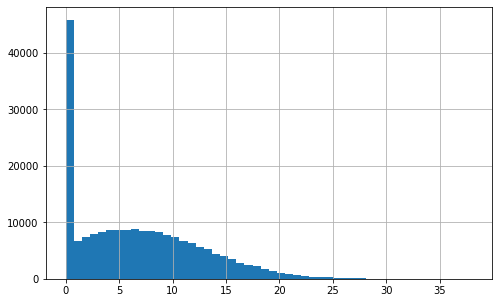

In [103]:
data_calls['duration'].hist(bins=50)
plt.show()

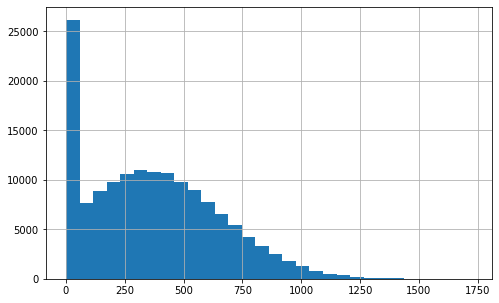

In [104]:
data_internet['mb_used'].hist(bins=30)
plt.show()

Как видно на гистограммах, имеется большое количество записей для звонком и сессий соединений с нулевыми значениями.
Т.к. данные скорее всего соответствуют попыткам дозвониться и попыткам получить соединени, на не их продолжительности, то полезной инхормации, кроме как о "настойчивости" клиена они нам не дадут. Скорее всего эта информация была бы полезна при определении причины отказа от услуг (является ли большое количество нулевых значений способствующим фактором?), или определения периодов с "проблемами" связи, Но это другая задача

Принимая вышесказанное предлагается удальть нулевые значения

In [105]:
data_calls = data_calls.loc[data_calls['duration'] != 0]
data_internet = data_internet.loc[data_internet['mb_used'] != 0]

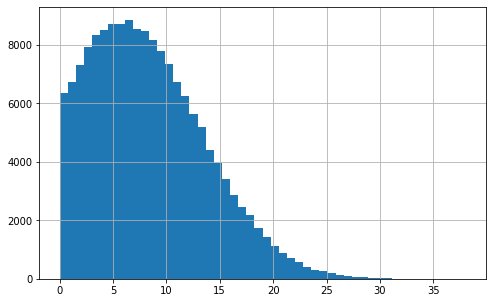

In [106]:
data_calls['duration'].hist(bins=50)
plt.show()

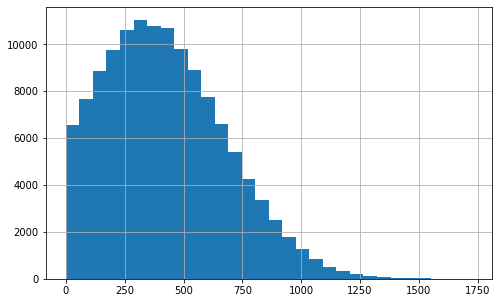

In [107]:
data_internet['mb_used'].hist(bins=30)
plt.show()

### 3. Округление значений

In [108]:
# Округлим минуты и Мегабайты до верхнего значения
data_calls['duration'] = np.ceil(data_calls['duration']).astype(int)
data_internet['mb_used'] = np.ceil(data_internet['mb_used']).astype(int)

#### 4.1. Минуты и количество звонков

т.к. для каждого пользователя начало месяца будет соответствовать дате его регистрации, то определим номер использования месяца для каждого пользователя и добавим в колонку `month`. Данная колонка будет хранить номер порядкогово месяца пользования услугами

In [109]:
def month_ordinal (df1, df2, column):
    """
    Функция возращает таблицу с добавленным столбецом 'month',
    число в столбце соответствует порядковому месяца использования от даты регистрации,
    и прибавляет номер календарного месяца, для соотнесения с календарным месяцем
    принимает df1, df2, column
    df1 - таблица, где содержится дата регистрации, соответствующего пользователя;
    df2 - таблица, где содержутся действиия(звонки, смс и т.п.), для которых нужно определить номер месяца
    column - название колонки, с датой действия 
    """
    
    #Добавим для вычислений дату регистрации для каждого пользователя
    df2 = df2.merge(df1[['reg_date', 'user_id']], how='right', on='user_id')
    #Удалим пользователей, которые не совершали никаких действий
    df2.dropna(inplace=True)
    
    #Найдем разницу в днях между датой действия и датой регистрации
    df2['month'] = pd.DatetimeIndex(df2[column]).month - pd.DatetimeIndex(df2['reg_date']).month


    #Найдем количество полных месяцев соответствующее каждой дате, начиная с первого и прибавим месяц регистрации
    df2['month'] = df2['month'] + pd.DatetimeIndex(df2['reg_date']).month


    #Удалим колонку с датой регистрации, т.к. она нам больше не нужна
    df2 = df2.drop(columns='reg_date')
    return df2

In [110]:
data_calls = month_ordinal(data_users, data_calls, 'call_date')

In [111]:
data_calls['duration'] = data_calls['duration'].astype(int)

In [112]:
#Сгруппируем суммарное количество минут по месяцам
pivot_sum_of_minutes_by_month = (
    data_calls
    .pivot_table(index='user_id', columns='month', values='duration', aggfunc=('sum'))
)
#Сгруппируем суммарное количество звонков по месяцам, исключая пропущенные (длительность 0)
pivot_numder_of_calls_by_month = (
    data_calls
    .pivot_table(index='user_id', columns='month', values='duration', aggfunc=('count'))
)

#### 4.2. Объем трафика 

т.к. для каждого пользователя начало месяца будет соответствовать дате его регистрации, то определим номер использования месяца для каждого пользователя и добавим в колонку `month_of_usage`. Данная колонка будет хранить номер порядкогово месяца пользования услугами

In [113]:
data_internet = month_ordinal(data_users, data_internet, 'session_date')

In [114]:
#Сгруппируем суммарное количество сообщений по месяцам
pivot_number_of_traffic_by_month = (
    data_internet
    .pivot_table(index='user_id', columns='month', values='mb_used', aggfunc=('sum'))
)

#### 4.3. Количество сообщений

т.к. для каждого пользователя начало месяца будет соответствовать дате его регистрации, то определим номер использования месяца для каждого пользователя и добавим в колонку `month_of_usage`. Данная колонка будет хранить номер порядкогово месяца пользования услугами

In [115]:
data_messages = month_ordinal(data_users, data_messages, 'message_date')

In [116]:
#Сгруппируем суммарное количество сообщений по месяцам
pivot_number_of_masseges_by_month = (
    data_messages
    .pivot_table(index='user_id', columns='month', values='message_date', aggfunc=('count'))
)

#### 4.4. Месячная выручка

Расчитаем выручку по месячно от звонков

In [117]:
#Добавим в таблицу вспомогательные столбцы в соответствии с user_id, для расчета
pivot_sum_of_minutes_by_month = (
    pivot_sum_of_minutes_by_month.merge(data_users[['tariff', 'user_id']], how='left', on='user_id')
)

pivot_sum_of_minutes_by_month = (
    pivot_sum_of_minutes_by_month.merge(data_tariffs[['tariff_name', 'minutes_included', 'rub_per_minute']],
                                        how='left', left_on='tariff', right_on='tariff_name')
)

In [118]:
#Создадим функцию, определяющую для каждого столбца(месяца) количесто израсходованных минут
#Если минут использовано больше чем лимит тарифа, то умножаем на соответствующую стоимость
#количество минут сверх лимита
def calls_income_compute (df):
    for i in range(12):
        if (df['minutes_included'] - df[i+1]) >= 0:
            df[i+1] = 0
        else: 
            df[i+1] = (df[i+1] - df['minutes_included']) * df['rub_per_minute']
    return df
#Применим функцию с нашему датафрейму с количеством минут за месяц, сохраним в новый df
calls_income = pivot_sum_of_minutes_by_month.apply(calls_income_compute, axis=1)
#Отбросим вспомогательные колонки используемые в расчете
calls_income = calls_income.drop(columns=['tariff', 'tariff_name', 'minutes_included', 'rub_per_minute'])

In [119]:
#Добавим всех пользователей, т.к. в исходной, только те, кто пользовался связью
calls_income = calls_income.merge(data_users['user_id'], how='right', on='user_id').sort_values(by='user_id')
#Установим индекс в качестве user_id для соединения с другими таблицами
calls_income = calls_income.set_index('user_id')
#Проверим данные
calls_income

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
1002,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1003,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00
1004,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00
1496,0.00,282.00,171.00,63.00,0.00,165.00,246.00,81.00,0.00,0.00,486.00,54.00
1497,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,135.00


Расчитаем выручку по месячно от сообщений

In [120]:
#Добавим в таблицу вспомогательные столбцы в соответствии с user_id, для расчета
pivot_number_of_masseges_by_month = (
    pivot_number_of_masseges_by_month.merge(data_users[['tariff', 'user_id']], how='left', on='user_id')
)

pivot_number_of_masseges_by_month = (
    pivot_number_of_masseges_by_month.merge(data_tariffs[['tariff_name', 'messages_included', 'rub_per_message']],
                                        how='left', left_on='tariff', right_on='tariff_name')
)

In [121]:
#Создадим функцию, определяющую для каждого столбца(месяца) количесто израсходованных сообщений
#Если сообщений использовано больше чем лимит тарифа, то умножаем на соответствующую стоимость
#количество сообщений сверх лимита
def mess_income_compute (df):
    for i in range(12):
        if (df['messages_included'] - df[i+1]) >= 0:
            df[i+1] = 0
        else: 
            df[i+1] = (df[i+1] - df['messages_included']) * df['rub_per_message']
    return df
#Применим функцию с нашему датафрейму с количеством смс за месяц, сохраним в новый df
mess_income = pivot_number_of_masseges_by_month.apply(mess_income_compute, axis=1)
#Отбросим вспомогательные колонки используемые в расчете
mess_income = mess_income.drop(columns=['tariff', 'tariff_name', 'messages_included', 'rub_per_message'])

In [122]:
#Добавим всех пользователей, т.к. в исходной, только те, кто пользовался связью
mess_income = mess_income.merge(data_users['user_id'], how='right', on='user_id').sort_values(by='user_id')
#Установим индекс в качестве user_id для соединения с другими таблицами
mess_income = mess_income.set_index('user_id')
mess_income

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1002,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1003,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00
1004,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00
1496,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
1497,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00


Расчитаем выручку по месячно от использования интернета

In [123]:
#Добавим в таблицу вспомогательные столбцы в соответствии с user_id, для расчета
pivot_number_of_traffic_by_month = (
    pivot_number_of_traffic_by_month.merge(data_users[['tariff', 'user_id']], how='left', on='user_id')
)

pivot_number_of_traffic_by_month = (
    pivot_number_of_traffic_by_month.merge(data_tariffs[['tariff_name', 'mb_per_month_included', 'rub_per_gb']],
                                        how='left', left_on='tariff', right_on='tariff_name')
)

In [124]:
#Создадим функцию, определяющую для каждого столбца(месяца) количесто израсходованных Мб
#Если Мб использовано больше чем лимит тарифа, то умножаем на соответствующую стоимость
#количество Мб сверх лимита
def traffic_income_compute (df):
    for i in range(12):
        if (df['mb_per_month_included'] - df[i+1]) >= 0:
            df[i+1] = 0
        else: 
            df[i+1] = np.ceil((df[i+1] - df['mb_per_month_included'])/ 1024) * df['rub_per_gb']
    return df
#Применим функцию с нашему датафрейму с количеством Мб за месяц, сохраним в новый df
traffic_income = pivot_number_of_traffic_by_month.apply(traffic_income_compute, axis=1)
#Отбросим вспомогательные колонки используемые в расчете
traffic_income = traffic_income.drop(columns=['tariff', 'tariff_name', 'mb_per_month_included', 'rub_per_gb'])

In [125]:
#Добавим всех пользователей, т.к. в исходной, только те, кто пользовался связью
traffic_income = traffic_income.merge(data_users['user_id'], how='right', on='user_id').sort_values(by='user_id')
#Установим индекс в качестве user_id для соединения с другими таблицами
traffic_income = traffic_income.set_index('user_id')
traffic_income

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,800.00,0.00
1002,nan,nan,nan,nan,nan,0.00,600.00,"1,000.00",400.00,0.00,800.00,600.00
1003,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00
1004,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,nan,nan,nan,nan,nan,nan,nan,0.00,450.00,0.00,"1,350.00",0.00
1496,0.00,"2,600.00","2,000.00","1,200.00","1,800.00","1,000.00","1,800.00","1,800.00","2,400.00","2,600.00","2,000.00","1,200.00"
1497,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,"1,000.00"


Расчитаем выручку от абонентской платы

In [126]:
#Определим номер месяца начала пользования тарифом и конец(если есть)
data_users['reg_month'] = pd.DatetimeIndex(data_users['reg_date']).month
data_users['churn_month'] = (
    pd.DatetimeIndex(data_users['churn_date']).month 
)

In [127]:
#Создадим сводную с месяцем регистрации и разбивкой по месяцам (в дальнейшем будем ее заполнять)
data_users_pivot = (
    data_users
    .pivot_table(index='user_id', columns='reg_month', values=('reg_date'), aggfunc=('count'))
)
#Для абонентов, кто не прекратил пользоваться связью в текущем году, установим номер месяца больше 12-го (13)
data_users['churn_month'] = data_users['churn_month'].fillna(13)

In [128]:
#Добавим вспомогательные колонки для расчета стоимости абонентской платы
data_users_pivot = data_users_pivot\
    .merge(data_users[['reg_month', 'churn_month', 'user_id', 'tariff']], how='left', on='user_id')

data_users_pivot = data_users_pivot\
    .merge(data_tariffs[['tariff_name', 'rub_monthly_fee']], how='left', left_on='tariff', right_on='tariff_name')

In [129]:
#Создадим функцию определяющую для каждого месяца аб. плату, если месяц равен или после месяца регистрации
#и до месяца прекращения (если он есть)
def fee_incom_compute (df):
    for i in range(12):
        if (i+1 >= df['reg_month']) & (i+1 <= df['churn_month']): 
            df[i+1] = df['rub_monthly_fee']
        else:
            df[i+1] = 0
    return df
        


In [130]:
#Применим функцию для заполнения нашей сводной таблицы, сохраним в номую переменную
fee_income = data_users_pivot.apply(fee_incom_compute, axis=1)
fee_income = fee_income.drop(columns=['reg_month', 'churn_month', 'tariff', 'tariff_name', 'rub_monthly_fee'])
fee_income = fee_income.set_index('user_id')

In [131]:
#Т.к. абонентская плата взымается всегда,
#а также присутствуют пользователи, которые не используют определенный вид связи
# то для того, чтобы корректно сложить значения для каждого пользователя, заменим пропуски на нули
total_income = fee_income.fillna(0) + traffic_income.fillna(0) + calls_income.fillna(0) + mess_income.fillna(0)
total_income = total_income.astype(int)

In [132]:
#Вернем значения Nan для месяцев где пользователь не использовал связь
for x in total_income.columns:
    total_income.loc[total_income[x] == 0, x] = np.nan
total_income

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,nan,nan,nan,nan,"1,950.00","1,950.00","1,950.00","1,950.00","1,950.00","1,950.00","1,950.00","1,950.00"
1001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"1,350.00",550.00
1002,nan,nan,nan,nan,nan,550.00,"1,150.00","1,550.00",950.00,550.00,"1,350.00","1,150.00"
1003,nan,nan,nan,nan,nan,nan,nan,"1,950.00","1,950.00","1,950.00","1,950.00","1,950.00"
1004,nan,nan,nan,nan,"1,950.00","1,950.00","1,950.00","1,950.00","1,950.00","1,950.00","1,950.00","1,950.00"
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,nan,nan,nan,nan,nan,nan,nan,"1,950.00","2,400.00","1,950.00","3,300.00","1,950.00"
1496,550.00,"3,432.00","2,721.00","1,813.00","2,350.00","1,715.00","2,596.00","2,431.00","2,950.00","3,150.00","3,036.00","1,807.00"
1497,nan,nan,nan,nan,nan,nan,nan,nan,nan,550.00,550.00,"1,685.00"


### Вывод
На данном этапе подготовили данные для расчетов в дальнейших шагах
1. Проверили наличие ошибок:
 + критических ошибок не обнаружено
 + нулевые значения принято исключить, т.к. они не несут информации о стоимости звонка(Мб) и использовании лимита, отведенного на тарифе, скорее всего это пропущенные вызовы
 + Проверили корректность дат регистрации и совершенных действий - все действия пользователя были после даты регистрации

2. Определили ежемесечную выручку от каждого пользователя и сохранили в 5-ти переменных:
 + calls_income - выручка от звонков
 + mess_income - выручка от смс
 + traffic_income - выручка от использования интернета
 + fee_income - выручка от абонентской платы
 + total_income - общая выручка

## 3. Проанализируем данные

#### 3.1 Расчитаем среднеемесяцное значения для каждого абонента
Использование минут разговора

In [133]:
#Подготовим данные
pivot_sum_of_minutes_by_month = (
    pivot_sum_of_minutes_by_month.drop(columns=['tariff', 'tariff_name', 'minutes_included', 'rub_per_minute'])
)
#Добавим всех абонентов, даже тех, кто не пользуется связью
pivot_sum_of_minutes_by_month = (
    pivot_sum_of_minutes_by_month.merge(data_users['user_id'], how='right', on='user_id').sort_values(by='user_id')
)
pivot_sum_of_minutes_by_month = pivot_sum_of_minutes_by_month.set_index('user_id')

In [134]:
#Расчитаем среднее для каждого пользователя в течение года
cols = range(1, 13)
pivot_sum_of_minutes_by_month['minut_month_mean'] = pivot_sum_of_minutes_by_month[cols].mean(axis=1)

Расчитаем среднеемесячное сообщений для каждого абонента

In [135]:
#Подготовим данные
pivot_number_of_masseges_by_month = (
    pivot_number_of_masseges_by_month.drop(columns=['tariff', 'tariff_name', 'messages_included', 'rub_per_message'])
)
#Добавим всех абонентов, даже тех, кто не пользуется связью
pivot_number_of_masseges_by_month = (
    pivot_number_of_masseges_by_month.merge(data_users['user_id'], how='right', on='user_id').sort_values(by='user_id')
)
pivot_number_of_masseges_by_month = pivot_number_of_masseges_by_month.set_index('user_id')

In [136]:
#Расчитаем среднее для каждого пользователя в течение года
cols = range(1, 13)
pivot_number_of_masseges_by_month['mess_month_mean'] = pivot_number_of_masseges_by_month[cols].mean(axis=1)

Расчитаем среднеемесячное количество Мб траффика для каждого абонента

In [137]:
#Подготовим данные
pivot_number_of_traffic_by_month = (
    pivot_number_of_traffic_by_month.drop(columns=['tariff', 'tariff_name', 'mb_per_month_included', 'rub_per_gb'])
)
#Добавим всех абонентов, даже тех, кто не пользуется связью
pivot_number_of_traffic_by_month = (
    pivot_number_of_traffic_by_month.merge(data_users['user_id'], how='right', on='user_id').sort_values(by='user_id')
)
pivot_number_of_traffic_by_month = pivot_number_of_traffic_by_month.set_index('user_id')

In [138]:
#Расчитаем среднее для каждого пользователя в течение года
cols = range(1, 13)
pivot_number_of_traffic_by_month['traff_month_mean'] = pivot_number_of_traffic_by_month[cols].mean(axis=1)

Создадим одну таблицу со столбцами в которых указаны средние значения для каждого пользователя

In [139]:
#добавим колонки с user_id и наименованием тарифа
data_monthly_mean = pivot_sum_of_minutes_by_month.merge(data_users[['user_id', 'tariff']], on='user_id')
#отбросим колонки с распределением по месяцам
data_monthly_mean = data_monthly_mean.drop(columns=(range(1,13)))

In [140]:
#добавим колонки со средними значениями для трафика и смс
data_monthly_mean = data_monthly_mean\
    .merge(pivot_number_of_traffic_by_month['traff_month_mean'], on='user_id')\
    .merge(pivot_number_of_masseges_by_month['mess_month_mean'], on='user_id')

In [141]:
#Изменим порядок, для удобного чтения
data_monthly_mean = data_monthly_mean[['user_id', 'tariff',
                                      'minut_month_mean', 'traff_month_mean',
                                        'mess_month_mean']]
data_monthly_mean

,user_id,tariff,minut_month_mean,traff_month_mean,mess_month_mean
0,1000,ultra,320.75,"13,436.50",62.00
1,1001,smart,422.00,"16,252.50",nan
2,1002,smart,216.71,"16,597.57",10.00
3,1003,ultra,764.40,"11,465.80",76.00
4,1004,ultra,123.38,"18,646.50",149.00
...,...,...,...,...,...
495,1495,ultra,784.00,"25,507.20",68.00
496,1496,smart,498.67,"22,605.75",39.00
497,1497,smart,468.67,"15,208.67",17.00
498,1498,smart,323.25,"18,631.50",42.00


Расчитаем среднеемесячную выручку для каждого абонента

In [142]:
#Расчитаем среднее для каждого пользователя в течение года
total_income['monthly_income_mean'] = total_income.mean(axis=1)

#Добавим колонку со средней выручкой в имеющуюся таблицу data_monthly_mean
data_monthly_mean = data_monthly_mean.join(total_income.reset_index()['monthly_income_mean'])

Получили выборки по двум тарифам с среднемесячным использованием услуг каждым пользователем

In [143]:
data_monthly_mean_smart = data_monthly_mean.loc[data_monthly_mean['tariff'] == 'smart']
data_monthly_mean_ultra = data_monthly_mean.loc[data_monthly_mean['tariff'] == 'ultra']

#### 3.2. Посчитайте среднее количество, дисперсию и стандартное отклонение

In [144]:
#Создадим словарь с колонками и их описанием
cols_dict={'minut_month_mean' : 'ежемесячное среднее количество минут',
           'traff_month_mean' : 'ежемесячное среднее количество Мегабайт',
           'mess_month_mean' : 'ежемесячное среднее количество смс', 
           'monthly_income_mean' : 'средняя ежемесячная выручка'}

In [145]:
#Посчитаем среднее, дисперсию и стандартное для тарифа Смарт
metrics_smart_step3 = data_monthly_mean_smart[cols_dict.keys()].describe().loc[['mean', 'std']]
metrics_smart_step3.loc['var'] = (
    [np.var(data_monthly_mean_smart[x]) for x in data_monthly_mean_smart[cols_dict.keys()].columns]
)
metrics_smart_step3.rename(columns=lambda x: x.replace('_mean', '_smart'), inplace=True)

metrics_smart_step3\
    .style\
    .set_caption('Среднее, стандартное отклонение и дисперсия для каждой из величин, тарифа "Смарт"')

,minut_month_smart,traff_month_smart,mess_month_smart,monthly_income_smart
mean,420.848,16237,37.5756,1327.51
std,143.451,3627.14,24.8497,607.412
var,20519.3,1.31185e+07,615.465,367898


Как видно, очень большие значения для колонки `traff_month_ultra` - не удобны для чтения, переведем Мегабайты в Гигабайты

In [146]:
#Изменим название в словаре
cols_dict['traff_month_mean'] = 'ежемесячное среднее количество Гигабайт'

#Изменим значения Мб на Гб в наших таблицах
data_monthly_mean_smart['traff_month_mean'] = data_monthly_mean_smart['traff_month_mean']/1024
data_monthly_mean_ultra['traff_month_mean'] = data_monthly_mean_ultra['traff_month_mean']/1024

In [147]:
#пересчитаем
metrics_smart_step3 = data_monthly_mean_smart[cols_dict.keys()].describe().loc[['mean', 'std']]
metrics_smart_step3.loc['var'] = (
    [np.var(data_monthly_mean_smart[x]) for x in data_monthly_mean_smart[cols_dict.keys()].columns]
)
metrics_smart_step3.rename(columns=lambda x: x.replace('_mean', '_smart'), inplace=True)

metrics_smart_step3\
    .style\
    .set_caption('Среднее, стандартное отклонение и дисперсия для каждой из величин, тарифа "Смарт"')

,minut_month_smart,traff_month_smart,mess_month_smart,monthly_income_smart
mean,420.848,15.8564,37.5756,1327.51
std,143.451,3.54212,24.8497,607.412
var,20519.3,12.5108,615.465,367898


In [148]:
#Для тарифа Ультра

metrics_ultra_step3 = data_monthly_mean_ultra[cols_dict.keys()].describe().loc[['mean', 'std']]
metrics_ultra_step3.loc['var'] = (
    [np.var(data_monthly_mean_ultra[x]) for x in data_monthly_mean_ultra[cols_dict.keys()].columns]
)
metrics_ultra_step3.rename(columns=lambda x: x.replace('_mean', '_ultra'), inplace=True)

metrics_ultra_step3\
    .style\
    .set_caption('Среднее, стандартное отклонение и дисперсия для каждой из величин, тарифа "Ультра"')

,minut_month_ultra,traff_month_ultra,mess_month_ultra,monthly_income_ultra
mean,546.998,19.2993,64.5558,2086.5
std,268.09,7.98573,43.3906,300.041
var,71369.5,63.338,1867.56,89420.2


In [149]:
metrics_smart_step3\
    .style\
    .set_caption('Среднее, стандартное отклонение и дисперсия для каждой из величин, тарифа "Смарт"')


,minut_month_smart,traff_month_smart,mess_month_smart,monthly_income_smart
mean,420.848,15.8564,37.5756,1327.51
std,143.451,3.54212,24.8497,607.412
var,20519.3,12.5108,615.465,367898


#### Вывод:
1. В среднем на тарифе Ультра пользуются среднемесячное значение использованных минут больше почти на 30%
2. На 20% больше используют интернет
3. и почти в 2 раза больше пользуются смс
4. Стандартные отклонения на тарифе Смарт меньше почти в 2 раза, чем на Ультра, говорит о том, значения средние значения для тарифа Смарт более однородные, больший разброс средних значений соответствует тарифу Ультра.
5. Для значений ежемесячного дохода наблюдается следующая картина:
 + В среднее показывает то, что пользователи тарифа Смарт платят меньше чем пользователи тарифа Ультра
 + Однако тарифу Смарт соответствует большая дисперсия и стандартное отклонение, получается, что:
    + верхняя граница платежей для тарифа смарт соответствует примерно mean + 3*std = 3149.746;
    + а для тарифа Ультра mean + 3*std = 2986.623
    + получается что некоторые пользователи на Смарте платят больше чем пользователи Ультра.
    + P.S. если правильно понял из теории тренажера, в такой ситуации необходимо проверить статистическим тестом гипотезы о равенстве или неравенстве средней выручки на тарифах, т.е. однозначно по среднему с такой большой дисперсией судить будет не корректно.

##### Распределение для тарифа Смарт

In [150]:
def hist_for_tarrif(df):
    for key in cols_dict.keys():
        data_for_hist = df.loc[df[key].notna(), key]
        sns.distplot(data_for_hist)
        plt.title('Распределение величины: {}'.format(cols_dict.get(key)))
        plt.show()

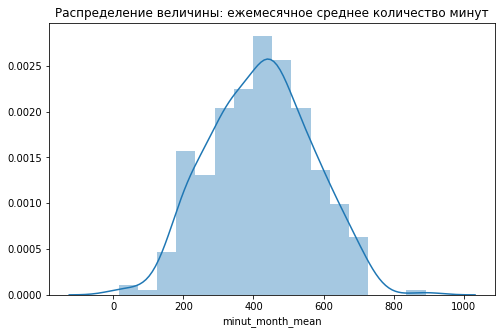

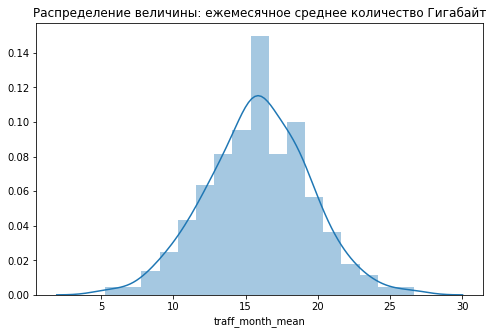

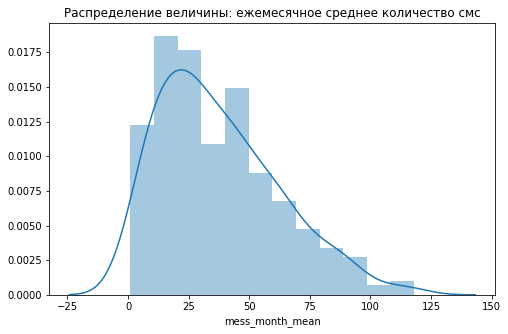

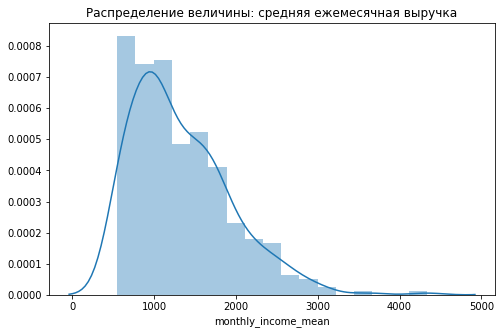

In [151]:
hist_for_tarrif(data_monthly_mean_smart)

#### Вывод:
1. Среднее распределение использования количества минут в месяц имеет тип близкий к нормальному, большинство пользователей разговаривают в среднем от 350 до 550 минут в месяц, небольшая часть разговаривает либо меньше 100 минут либо больше 800
2. Распределение величины среднего использование Гигабайт имеет нормальный тип распределения. Большей части пользователей требуется до 18 ГБ в месяц.
3. Смс пользователи используют не такое большое количество, основная масса пользователей до 50 сообщений в месяц, распределение больше соответствует Пуассону или дата сету скошенному в право
4. Распределение среднемесяцного дохода также соответствует больше Пуассоновскому, основная масса людей платит до 1500 рублей в месяц, но присутствуют пользователи которые платят 3000 и больше


##### Распределение для тарифа Ультра

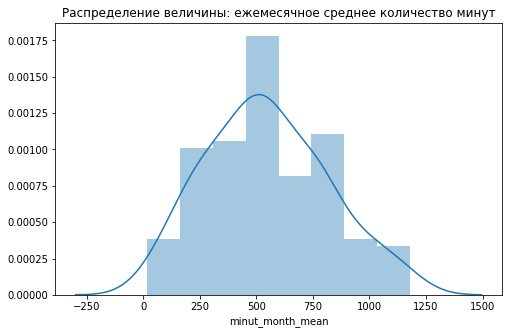

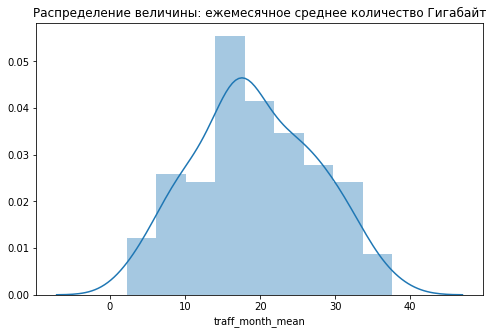

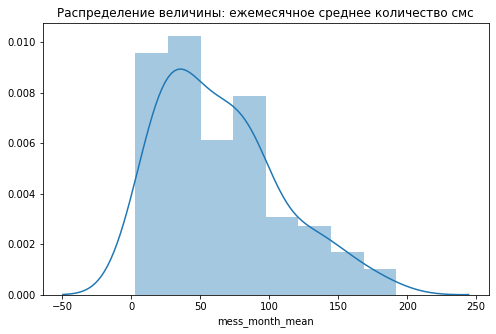

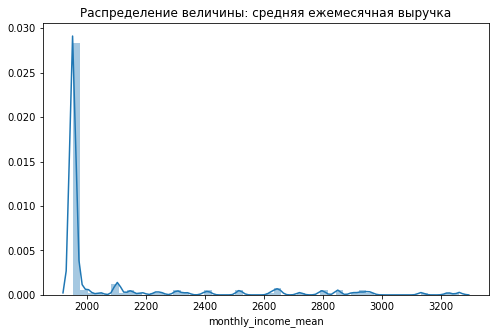

In [152]:
hist_for_tarrif(data_monthly_mean_ultra)

#### Вывод:

1. Среднее распределение использования количества минут в месяц имеет тип близкий к нормальному, большинство пользователей разговаривают в среднем около 500 минут в месяц, небольшая часть разговаривает либо меньше 150 минут либо больше 875
2. Распределение величины среднего использование Гигабайт имеет нормальный тип распределения. Большей части пользователей требуется до 25 ГБ в месяц.
3. Смс пользователи используют не такое большое количество, основная масса пользователей до 50 сообщений в месяц, распределение больше соответствует Пуассону или дата сету скошенному в право
4. Распределение среднемесяцного дохода также соответствует больше Пуассоновскому, основная масса людей платит только абонентскую плату, но присутствуют пользователи которые платят и свер ее.


## 4. Проверка гипотез

#### Проверим гипотезу о равенстве средней выручки для тарифов «Ультра» и «Смарт»
+ Для сравления двух выборок (тариф «Ультра» и «Смарт») воспользуемся методом `scipy.stats.ttest_ind()`
+ т.к. дисперсия отличается для двух выборок значительно отличается, что также видно по гистограммам, то принято параметр `equal_var ` принять равный `False`
+ Критический уровень статистической значимости выберем `alpha = 0.05`, в соответствии с общепринятыми пороговыми значениями
+ Нулевую гипотезу сформулируем исходя о равенстве средних, тогда:
 + H0 - средние значения для тарифов «Ультра» и «Смарт» равны;
 + Н1 - среднее значения для тарифа «Ультра» больше чем для тарифа «Смарт»;


In [153]:
def stat_ttest_ind_chek(set1, set2, alpha, eq_var=None, set1_name=None, set2_name=None):
    """
    Функция возращает результат принятия или отвержения гипотез:
    H0 - средние set1 = set2
    H1 - средние set1 < set2    
    """
    #Произведем статестический тест
    result = st.ttest_ind(
        set1,
        set2,
        equal_var=eq_var
    )
    print('p-value = ', result.pvalue)
    #Выведем результат:
    #Если p-value(уровень значимости, полученный путем определения разницы количества станрартных отклонений,
    #между сравниваемыми выличинами) меньше нашего критерия статистической значимости, то вероятность получить
    #выборку удовлетворяющую нашей гипотезе очень низкая
    print('Проверим нулевую гипотезу H0 - средние {} и {} равны:'.format(set1_name, set2_name))
    if (result.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
        print('Cредние значения различаются')
        print('\n\nПроверим альтернативную гипотезу H1 - среднее {} меньше среднего {}:'.format(set1_name, set2_name))
        
        if (result.pvalue / 2 < alpha) and (set1.mean() < set2.mean()):
            print('Не получилось отвергнуть альтернативную гипотезу')
        else:
            print("Отвергаем альтернативную гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    
    

In [154]:
stat_ttest_ind_chek(
    set1=data_monthly_mean_smart.monthly_income_mean,
    set2=data_monthly_mean_ultra.monthly_income_mean,
    alpha=0.05,
    eq_var=False,
    set1_name='Smart',
    set2_name='Ultra'
)

p-value =  5.26252224448908e-59
Проверим нулевую гипотезу H0 - средние Smart и Ultra равны:
Отвергаем нулевую гипотезу
Cредние значения различаются


Проверим альтернативную гипотезу H1 - среднее Smart меньше среднего Ultra:
Не получилось отвергнуть альтернативную гипотезу


Проверим для `alpha=0.01`

In [155]:
stat_ttest_ind_chek(
    set1=data_monthly_mean_smart.monthly_income_mean,
    set2=data_monthly_mean_ultra.monthly_income_mean,
    alpha=0.01,
    eq_var=False,
    set1_name='Smart',
    set2_name='Ultra'
)

p-value =  5.26252224448908e-59
Проверим нулевую гипотезу H0 - средние Smart и Ultra равны:
Отвергаем нулевую гипотезу
Cредние значения различаются


Проверим альтернативную гипотезу H1 - среднее Smart меньше среднего Ultra:
Не получилось отвергнуть альтернативную гипотезу


#### Проверим гипотезу 'средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов'
+ Для сравления двух выборок (выручка по москве и выручка по регионам) воспользуемся методом `scipy.stats.ttest_ind()`
+ т.к. дисперсия отличается для двух выборок значительно отличается, что также видно по гистограммам, то принято параметр `equal_var ` принять равный `False`
+ Критический уровень статистической значимости выберем `alpha = 0.05`, в соответствии с общепринятыми пороговыми значениями

Воспользуемся готовой функцией `stat_ttest_ind_chek`, тогда:
+ Нулевую гипотезу сформулируем исходя о равенстве средних, тогда:
 + H0 - средние значения выручки для Москвы и для регионов равны;
 + Н1 - среднее значения выручки для Москвы больше чем для регионов;


Подготовим данные, добавим колонку с городом и отсортируем

In [156]:
data_monthly_mean = data_monthly_mean.join(data_users['city'])

In [157]:
data_monthly_income_msk = (
    data_monthly_mean.loc[data_monthly_mean.city == 'Москва', 'monthly_income_mean']
)
data_monthly_income_regions  = (
    data_monthly_mean.loc[data_monthly_mean.city != 'Москва', 'monthly_income_mean']
)

Проверим для `alpha = 0.05`

In [158]:
stat_ttest_ind_chek(
    set1=data_monthly_income_regions,
    set2=data_monthly_income_msk,
    alpha=0.05,
    eq_var=False,
    set1_name='Регионы',
    set2_name='Москва'
)

p-value =  0.36837479573900667
Проверим нулевую гипотезу H0 - средние Регионы и Москва равны:
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу, следовательно гипотезу о том, что средние в Москве и регионах различаются придется отвергнуть, также это заметно по величене pvalue - почти 37%

### Вывод
1. В текущем шаге проверили гипотезы о равенстве выручек на тарифах "Ультра" и "Смарт"
2. Проверили гипотезы о равенстве выручек в Москве и Регионах.
3. По итогу получили:
 + что средняя выручка для тарифа "Ультра" больше чем для тарифа "Смарт"
 + средние выручки для Москвы и регионов не отличаются.


## Вывод

1. Общая информация о данных
 + Данные вполне подготовленными, дубликатов не обнаружено, необходимо произвести следующие подготовительные работы:
 + Привести к соответствующему виду дату и время
 + т.к. округление идет к верхней границе, то необходимо длительность звонков и мегабайтов траффка округлить до верхнего значения
 
 
2. Подготовка данных

 1. Проверили наличие ошибок:
    + В названии городов ошибок не выявлено
    + критических ошибок не обнаружено
    + нулевые значения принято исключить, т.к. они не несут информации о стоимости звонка(Мб) и использовании лимита, отведенного на тарифе, скорее всего это пропущенные вызовы
    + Проверили корректность дат регистрации и совершенных действий - все действия пользователя были после даты регистрации

 2. Определили ежемесечную выручку от каждого пользователя и сохранили в 5-ти переменных:
    + calls_income - выручка от звонков
    + mess_income - выручка от смс
    + traffic_income - выручка от использования интернета
    + fee_income - выручка от абонентской платы
    + total_income - общая выручка
    

3. Анализ данных:
 1. В среднем на тарифе Ультра пользуются среднемесячное значение использованных минут больше почти на 30%
 2. На 20% больше используют интернет
 3. и почти в 2 раза больше пользуются смс
 4. Стандартные отклонения на тарифе Смарт меньше почти в 2 раза, чем на Ультра, говорит о том, значения средние значения для тарифа Смарт более однородные, больший разброс средних значений соответствует тарифу Ультра.
 5. Для значений ежемесячного дохода наблюдается следующая картина:
    + В среднее показывает то, что пользователи тарифа Смарт платят меньше чем пользователи тарифа Ультра
    + Однако тарифу Смарт соответствует большая дисперсия и стандартное отклонение, получается, что:
       + верхняя граница платежей для тарифа смарт соответствует примерно mean + 3*std = 3149.746;
       + а для тарифа Ультра mean + 3*std = 2986.623
       + получается что некоторые пользователи на Смарте платят больше чем пользователи Ультра.
  
  
4. Анализ данных Тариф "Смарт"
 + Среднее распределение использования количества минут в месяц имеет тип близкий к нормальному, большинство пользователей разговаривают в среднем от 350 до 550 минут в месяц, небольшая часть разговаривает либо меньше 100 минут либо больше 800
 + Распределение величины среднего использование Гигабайт имеет нормальный тип распределения. Большей части пользователей требуется до 18 ГБ в месяц.
 + Смс пользователи используют не такое большое количество, основная масса пользователей до 50 сообщений в месяц, распределение больше соответствует Пуассону или дата сету скошенному в право
 + Распределение среднемесяцного дохода также соответствует больше Пуассоновскому, основная масса людей платит до 1500 рублей в месяц, но присутствуют пользователи которые платят 3000 и больше


5. Анализ данных Тариф "Ультра" 
 + Среднее распределение использования количества минут в месяц имеет тип близкий к нормальному, большинство пользователей разговаривают в среднем около 500 минут в месяц, небольшая часть разговаривает либо меньше 150 минут либо больше 875
 + Распределение величины среднего использование Гигабайт имеет нормальный тип распределения. Большей части пользователей требуется до 25 ГБ в месяц.
 + Смс пользователи используют не такое большое количество, основная масса пользователей до 50 сообщений в месяц, распределение больше соответствует Пуассону или дата сету скошенному в право
 + Распределение среднемесяцного дохода также соответствует больше Пуассоновскому, основная масса людей платит только абонентскую плату, но присутствуют пользователи которые платят и свер ее.


6. Проверка гипотез
 1. Проверили гипотезы о равенстве выручек на тарифах "Ультра" и "Смарт"
 2. Проверили гипотезы о равенстве выручек в Москве и Регионах.
 3. По итогу получили:
    + что средняя выручка для тарифа "Ультра" больше чем для тарифа "Смарт"
    + средние выручки для Москвы и регионов не отличаются.
    
Общий вывод:
1. Тариф  "Ультра" приносит больше выручки по сравнению с тарифом "Смарт"
2. У отдельных пользователей наблюдается больший ежемесечный платеж на тарифе "Смарт" чем средний(или даже максимальный) на тарифе "Ультра".